In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd  # To play sound in the notebook
import pyaudio
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from keras.models import load_model
import noisereduce as nr
import math, os, sys, time
import random
from threading import Thread

# matplotlib.use('Qt5Agg')
# plt.style.use('dark_background')
# plt.rc('figure', titlesize=16)
# plt.rc('axes', labelsize=12)

In [2]:
class emotion_detector:
    # ['angry', 'calm', 'disgust', 'fear', 'happy', 'sad', 'surprise']
    def __init__(self,
                 model_path,
                 gender_classifier=None,
                 sample_rate=22050,
                 threshold=122):
        self.MODEL = load_model(model_path)
        if gender_classifier != None:
            self.GC_MODEL = load_model(gender_classifier)
        else:
            self.GC_MODEL = False
        EMOTIONS = {
            0: 'Angry',
            1: 'Calm',
            2: 'Disgust',
            3: 'Fearful',
            4: 'Happy',
            5: 'Sad',
            6: 'Surprised'
        }
        self.genders = {0: 'Female', 1: 'Male'}
        self.ENC = OneHotEncoder()
        self.ENC.fit_transform([['Angry'], ['Calm'], ['Disgust'], ['Fearful'],
                                ['Happy'], ['Sad'], ['Surprised']])
        self.THRESHOLD = threshold
        self.FORMAT = pyaudio.paFloat32
        self.CHANNELS = 1
        self.RATE = sample_rate
        self.sr = self.RATE
        self.CHUNK = 1024 * 4
        self.COLORS = [
            'red', 'lightblue', 'peru', 'darkred', 'green', 'yellow',
            'lightpink'
        ]
        self.EMOTION_LIST = list(EMOTIONS.values())
        self.emotion = "Silence"
        self.gender = ""
        self.predictions = [0, 0, 0, 0, 0, 0, 0]
        self.total_predictions = []
        self.LENGTH = 121212
        self.AUDIO = pyaudio.PyAudio()
        self.FRAME_LENGTH = 2048
        self.HOP_LENGTH = 512
        self.RECORD_SECONDS = 2.6
        self.audio = (np.sin(np.pi * np.arange(self.RECORD_SECONDS) * 54 /
                             self.sr)).astype(np.float32)

        self.SCALER = StandardScaler()
        # self.FIG, self.AXES = plt.subplots(1,
        #                                    2,
        #                                    figsize=(14, 8),
        #                                    tight_layout=True)
        # self.FIG.canvas.mpl_connect('close_event', self.stop_stream)
        self.stop_flag = False
        self.emo_color = {
            self.EMOTION_LIST[i]: self.COLORS[i]
            for i in range(len(self.EMOTION_LIST))
        }
        self.emo_color["Silence"] = 'white'

    def __analyser(self, frame):
        pass
        # self.AXES[0].clear()
        # self.AXES[1].clear()

        # self.AXES[0].set_ylim(0, 1.2)
        # self.AXES[1].set_ylim(-1, 1)

        # plt.suptitle("\n\n\n" + self.emotion.capitalize() + " " + self.gender,
        #              va='center',
        #              fontweight="bold")
        # self.AXES[0].bar(self.EMOTION_LIST, self.predictions, color=self.COLORS)

        # librosa.display.waveshow(y=self.audio,
        #                          sr=self.sr,
        #                          ax=self.AXES[1],
        #                          color=self.emo_color[self.emotion])

    def __extract_features(self, audio, sr):
        rms = []
        mfcc = []
        mel = []

        # Fetch the sample rate.
        normalizedsound = librosa.util.normalize(audio)

        # Trim silence from the beginning and the end.
        trimmed_audio, index = librosa.effects.trim(y=normalizedsound,
                                                    top_db=30)

        final_audio = np.pad(trimmed_audio,
                             (0, self.LENGTH - len(trimmed_audio)), 'constant')
        # Noise reduction.
        final_audio = nr.reduce_noise(y=final_audio,
                                      sr=self.RATE)  #updated 03/03/22

        f1 = librosa.feature.rms(
            y=final_audio,
            frame_length=self.FRAME_LENGTH,
            hop_length=self.HOP_LENGTH).T  # Energy - Root Mean Square

        f2 = librosa.feature.melspectrogram(y=final_audio,
                                            sr=sr,
                                            n_fft=self.FRAME_LENGTH,
                                            hop_length=self.HOP_LENGTH).T

        f3 = librosa.feature.mfcc(y=final_audio,
                                  sr=sr,
                                  n_mfcc=40,
                                  hop_length=self.HOP_LENGTH).T  # MFCC

        # Filling the data lists

        rms.append(self.SCALER.fit_transform(f1))
        mel.append(self.SCALER.fit_transform(f2))
        mfcc.append(self.SCALER.fit_transform(f3))

        f_rms = np.asarray(rms)
        f_mel = np.asarray(mel)
        f_mfccs = np.asarray(mfcc)

        # Concatenating all features to 'X' variable.
        features = np.concatenate((f_rms, f_mel, f_mfccs), axis=2)
        return features

    def __emotion(self, audio_features):
        predictions = self.MODEL.predict(audio_features,
                                         use_multiprocessing=True)
        # print(predictions)

        max_emo = self.ENC.inverse_transform(predictions)
        pred_list = list(predictions)
        predictions = np.squeeze(np.array(pred_list).tolist(), axis=0)
        # print(predictions)

        return predictions, max_emo[0][0]

    def __gender(self, audio_features):
        if not self.GC_MODEL:
            return ""
        else:
            predictions = self.GC_MODEL.predict(audio_features,
                                                use_multiprocessing=True)
            print('gender_prediction={}'.format(predictions))

            prediction = int(predictions.round()[0][0])
            # predictions = np.squeeze(np.array(pred_list).tolist(), axis=0)
            print('gender_prediction={}'.format(prediction))

            return self.genders[prediction]

    def list_devices(self):
        print("----------------------record device list---------------------")
        info = self.AUDIO.get_host_api_info_by_index(0)
        numdevices = info.get('deviceCount')
        for i in range(0, numdevices):
            if (self.AUDIO.get_device_info_by_host_api_device_index(
                    0, i).get('maxInputChannels')) > 0:
                print(
                    "Input Device id ", i, " - ",
                    self.AUDIO.get_device_info_by_host_api_device_index(
                        0, i).get('name'))

        print("-------------------------------------------------------------")

        index = int(input())
        return index

    def silence(self, audio):
        threshold = (sum(audio) / len(audio))
        # print(threshold)
        return (sum(audio) / len(audio)) < self.THRESHOLD

    def start(self, file=None, device_index=None):
        self.total_predictions = []

        if file != None:
            try:
                audio_data, self.sr = librosa.load(file)
                ipd.display(ipd.Audio(data=audio_data, rate=self.sr))
                n = len(audio_data) / self.LENGTH
                if n < 1:
                    self.audio = audio_data
                    features = self.__extract_features(audio_data, self.sr)
                    self.predictions, self.emotion = self.__emotion(features)
                    self.gender = self.__gender(features)
                    print(self.predictions, self.emotion,self.gender)
                    return self.predictions, self.emotion,self.gender
                else:
                    for i in range(math.floor(n)):
                        self.audio = audio_data[self.LENGTH * i:self.LENGTH *
                                                (i + 1)]
                        features = self.__extract_features(audio, self.sr)
                        self.predictions, self.emotion = self.__emotion(
                            features)
                        self.gender = self.__gender(features)
                        self.total_predictions.append(self.predictions)
                        print(self.predictions, self.emotion)

                    else:
                        self.audio = audio_data[self.LENGTH * i:]
                        features = self.__extract_features(audio, self.sr)
                        self.predictions, self.emotion = self.__emotion(features)
                        self.gender = self.__gender(features)
                        self.total_predictions.append(self.predictions)
                        print(self.predictions, self.emotion)

            except Exception as e:
                print(e)

        else:
            if device_index == None:
                print("Missing Device Index Or File !")
                sys.exit(1)
                # index = self.list_devices()
            print("recording via index " + str(device_index))

            self.STREAM = self.AUDIO.open(format=self.FORMAT,
                                          channels=self.CHANNELS,
                                          rate=self.RATE,
                                          input=True,
                                          input_device_index=device_index,
                                          frames_per_buffer=self.CHUNK)
            self.sr = self.RATE
            n = int(self.RATE / self.CHUNK * self.RECORD_SECONDS)
            # print(n)
            # try:
            while not self.stop_flag:
                # print("recording started")
                Recordframes = []
                for i in range(0, n):
                    data = self.STREAM.read(self.CHUNK,
                                            exception_on_overflow=False)
                    Recordframes.append(data)
                # print ("recording stopped")
                # print(len(Recordframes))
                self.audio = np.frombuffer(b''.join(Recordframes),
                                           dtype=np.float32)
                # ipd.display(ipd.Audio(data=self.audio, rate=self.RATE))
                # time.sleep(5)
                if self.silence(b''.join(Recordframes[-4:])):
                    # print("Silence Detected !")
                    self.emotion = "Silence"
                    self.gender = ""
                    self.predictions = [0, 0, 0, 0, 0, 0, 0]
                else:
                    features = self.__extract_features(self.audio, self.RATE)
                    self.gender = self.__gender(features)
                    self.predictions, self.emotion = self.__emotion(features)
                    self.total_predictions.append(self.predictions)
                    # print(emotion)

        print("Main Thread Terminated !")

    def start_stream(self, file=None, device_index=None):
        print("Stream Started !")
        self.start(file,device_index)
        # self.main_thread = Thread(target=self.__start,
        #                           args=(file, device_index))
        # self.main_thread.start()
        print('self.total_predictions = {}'.format(self.total_predictions))
        # self.anim = FuncAnimation(fig=self.FIG,
        #                           func=self.__analyser,
        #                           interval=1)
        # plt.show()
        # FIG, AXES = plt.subplots(1, 1, figsize=(14, 8), tight_layout=True)
        # AXES.set_ylim(0, 1.2)
        # plt.suptitle("\n\n\nSummary", va='center', fontweight="bold")
        # total_predictions = np.mean(np.array(self.total_predictions).tolist(),
        #                             axis=0)
        # print('total_prediction = {}'.format(total_predictions))
        # AXES.bar(self.EMOTION_LIST, total_predictions, color=self.COLORS)
        # plt.show()
        

    def stop_stream(self, event=None):
        self.stop_flag = True
        self.main_thread.join()
        self.STREAM.stop_stream()
        self.STREAM.close()
        self.AUDIO.terminate()
        print("Stream Stoped !")

In [ ]:
# ed = emotion_detector('Models/SER.hdf5', "Models/Gender_Classifier.hdf5")
# device_index = ed.list_devices()
# ed.start_stream(device_index=device_index)

In [3]:
RAVDESS = "Data/RAVDESS/audio_speech_actors_01-24/"
TESS = "Data/TESS/"
TESS = "Data/TEST/"
datafiles = []
for i in os.listdir(TESS):
    datafiles.append(TESS + i)

# for i in os.listdir(RAVDESS):
#     if os.path.isdir(RAVDESS + i):
#         for j in os.listdir(RAVDESS + i):
#             datafiles.append(RAVDESS + i + '/' + j)

In [4]:
ed = emotion_detector('Models/SER.hdf5', "Models/Gender_Classifier.hdf5")
file = random.choice(datafiles)
print(file)
emotion_pred_list,emotion_pred,gender_pred = ed.start(file=file)
EMOTIONS = {
            0: 'Angry',
            1: 'Calm',
            2: 'Disgust',
            3: 'Fearful',
            4: 'Happy',
            5: 'Sad',
            6: 'Surprised'
        }


Data/TEST/OAF_back_happy.wav


1/1 [==============================] - 1s 591ms/step
gender_prediction=[[0.9999917]]
gender_prediction=1
[1.01125725e-05 3.26478122e-10 1.63503546e-06 3.85413296e-05
 9.99626994e-01 2.16812648e-08 3.22664739e-04] Happy Male


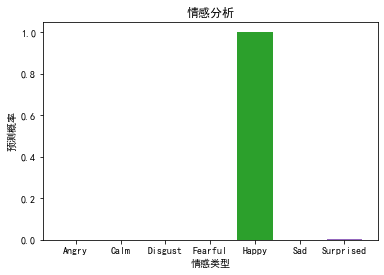

AttributeError: module 'matplotlib' has no attribute 'pyplot'

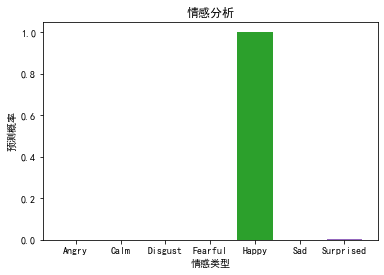

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [9]:
import matplotlib.pyplot as plt


# 正确显示中文和负号
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

# 画图，plt.bar()可以画柱状图
for i in range(len(emotion_pred_list)):
	plt.bar(EMOTIONS[i],emotion_pred_list[i])
# 设置图片名称
plt.title("情感分析")
# 设置x轴标签名
plt.xlabel("情感类型")
# 设置y轴标签名
plt.ylabel("预测概率")
# 显示
plt.show()
